# Analysis of Split ECG latent space for Model Poisoning Detection

In [35]:
import numpy as np
import os
from torch.nn.functional import max_pool1d, avg_pool1d
import torch
import pickle
import pandas as pd
import scipy.spatial as sp
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from functools import partial
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from contextlib import closing
import itertools
#from tqdm.notebook import tqdm
from tqdm import tqdm
import math
from server.security.analysis import *
import client.utils as utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Multi-Client Experiments

#### Key Assumptions from the presentation
1. Latent representation of datapoints should only slightly change between epochs 
2. Points of similar classes are close to each other in the latent space
3. Poisoned datapoints have higher loss contributions than regular datapoints

The following metrics and visualizations are interesting to determine if our assumptions (1), (2), and (3) are valid in the multi-client setup.

### Robust Latent Representation

TBA

### Pairwise Class Similarity to Latent Space Proximity

To verify this assumption we use summaries of per-client and per-class pairwise similariities + t-SNE visualization. We do the same for the malicious client vs the honest clients:
- First and second moment + median of pairwise similarities for different similarity measures (primarily Minkowski)
- Comparison of results for fixed class over epochs (plot lines)
- t-SNE visualization of the latent space for fixed class and different epochs

In [2]:
similarities = ["cosine", "euclidean", "cityblock", "correlation", "seuclidean"]
epochs = 30
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_two_malicious_0.25_0.25"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))

#### Label Distribution

In [ ]:
df = pd.DataFrame()
for client_id in range(1, 6):
    samples = pd.read_pickle(os.path.join(base_path, "client_" + str(client_id), "epoch_" + str(1) + ".pickle"))
    samples.label = samples.label.apply(lambda x: np.sum(x * 2**np.arange(x.size)[::-1]))
    single_class = samples[samples.label.apply(lambda x: is_power_of_2(x))]
    col = single_class.label.value_counts().sort_index().rename("client_" + str(client_id))
    df = pd.concat([df, col], axis=1)

df

#### Moments of Pairwise Similarities

In [ ]:
df_clients = pd.DataFrame(columns=["client_id"])
for idx in range(1, metadata["num_clients"] + 1):
    client_path = os.path.join(base_path, "client_" + str(idx))
    save_path = os.path.join(client_path, "similarities.pickle")
    df = compute_in_parallel(client_path, epochs, similarities, num_workers=multiprocessing.cpu_count(), aggregate=True, pooling=None, split="knn_10_euclidean")
    df["client_id"] = idx
    df_clients = pd.concat([df_clients, df], axis=0, ignore_index=True)

#### Plotting Similarity Metrics for Fixed Class and Individual Clients

In [ ]:
plot_all_similarities(df_clients, moment, similarities=similarities)

In [ ]:
# 0.2 / 0.5
for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment, similarities=similarities)

In [ ]:
# 0.01 / 0.25
for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment, similarities=similarities)

In [ ]:
# 0.1 / 0.5
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment, similarities=similarities)

In [ ]:
# 0.01 / 0.01
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment)

In [ ]:
# 0.5 / 0.1
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment)

In [ ]:
# 0.2 / 0.1
moment = "mean"

for l in df_clients.label.unique():
    plot_all_similarities(df_clients, l, moment)

#### t-SNE Visualization

In [ ]:
epoch_path = os.path.join(base_path, "client_1", "epoch_" + str(1) + ".pickle")
samples = pickle.load(open(epoch_path, "rb"))
samples.columns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 0.2 / 0.5

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn_10_euclidean")

In [ ]:
# 0.1 / 0.5

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn5")

In [ ]:
# 0.01 / 0.01

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn5")

In [ ]:
# 0.5 / 0.1

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn5")

In [ ]:
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_one_malicious_0.01_0.25"

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn_5_euclidean")


In [ ]:
base_path = "/home/mohkoh/Projects/Split_ECG_Classification/latent_space/multi_client_one_malicious_0.2_0.1"

params = {
    "n_components": 2, 
    "perplexity": 35, 
    "n_iter": 1000, 
    "verbose": 0, 
    "random_state": 0,
    #"learning_rate": "auto",
    #"init": "pca",
    #"n_jobs": 20
}

fig, ax = per_epoch_tsne([1, 15, 30], base_path, 5, params, pooling=None, pca=50, split="knn_5_euclidean")


### Higher Loss Contribution of Corrupted Points and Malicious Client

- Loss contribution of client per epoch 
- Also some moments for the loss of each client per epoch

In [ ]:
plot_loss(loss_contributions(base_path, metadata=metadata), "mean")

In [ ]:
plot_loss(loss_contributions(base_path, "mean"), "mean")

In [ ]:
plot_loss(loss_contributions(base_path, "var"), "var")

In [ ]:
plot_loss(loss_contributions(base_path, "std"), "std")

In [ ]:
plot_loss(loss_contributions(base_path, "sum"), "sum")

## Detection Mechanism

We confirmed our assumptions (1), (2), and (3) for the multi-client setup. Now we can use the following metrics to detect model poisoning:
- Loss contribution of client per epoch	
- Cosine similarity, Correlation , Standardized Euclidean Distance

We will try out different ideas for the detection mechanism and compare them to each other

### Naive Approaches

In [2]:
similarities = ["cosine", "correlation", "seuclidean"]
epochs = 30
N = 10
M = 4
p = 0.5
iid = True
base_path = f"/home/mohkoh/projects/Split_ECG_Classification/latent_space/IID={iid}_N={N}_M={M}_type=LF_p={p}"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))

In [6]:
df_base = pd.DataFrame()
for idx in tqdm(range(N), desc=f"Load Data Frames"):
    for epoch in range(1, epochs + 1):
        client_path = os.path.join(base_path, "client_" + str(idx))
        df = pd.read_pickle(os.path.join(client_path, "epoch_{}.pickle".format(epoch)))
        df["client_id"] = idx
        df_base = pd.concat([df_base, df], axis=0, ignore_index=True)

Load Data Frames:   0%|          | 0/10 [00:00<?, ?it/s]

client_id
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: loss, dtype: object

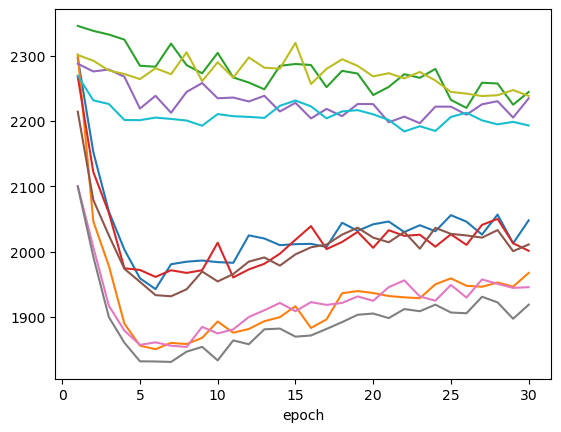

In [7]:
lc = loss_contributions(df_base, num_clients=metadata["num_clients"] + 1, epochs=30, moment="sum")
lc.reset_index().set_index("epoch").groupby("client_id")["loss"].plot()

In [8]:
df_clients = client_scores(num_clients=N, num_workers=multiprocessing.cpu_count(), df_base=df_base, epochs=30, method="similarity", pooling="max", split="knn_10_euclidean", similarities=similarities)

|Client x Epoch|:   0%|          | 0/300 [00:00<?, ?it/s]

client_id
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

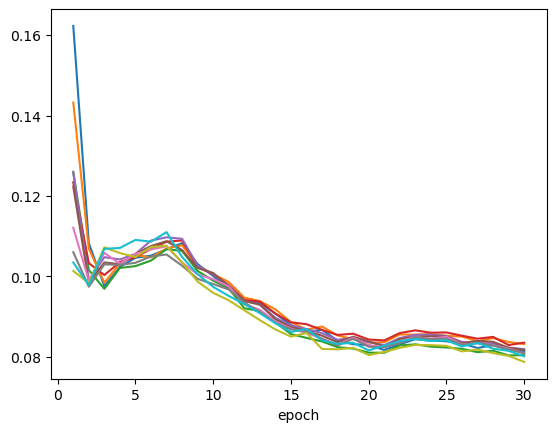

In [9]:
df_clients_global = df_clients.groupby(["client_id", "epoch"]).mean()
df_clients_global.reset_index(inplace=True)
df_clients_global.set_index("epoch", inplace=True)
df_clients_global.groupby("client_id")["cosine"].plot()

In [7]:
df_tmp = df_clients_global.copy()

In [53]:
df_clients_global = df_clients_global[df_clients_global.client_id.isin([3, 4, 5])]

In [70]:
df_clients_global = df_tmp.copy()

In [71]:
def point_contribution_mean(x, similarities):
    dataset = x[similarities].values
    
    # Step 1: Calculate the mean
    mean = np.mean(dataset)

    # Step 2: Compute the variance
    variance = np.var(dataset)

    # Step 3: Invert the variance to obtain the precision matrix
    precision = 1 / variance

    # Step 4: Calculate the squared Mahalanobis distance for each data point
    mahalanobis_distances = np.exp(-((dataset - mean) ** 2) / (2 * (np.sqrt(variance) ** 2)))

    # Step 5: Normalize the squared Mahalanobis distances
    normalized_contributions = mahalanobis_distances / np.max(mahalanobis_distances)

    # weighting_factor = (mahalanobis_distances / variance) / np.sum(mahalanobis_distances / variance)

    # # Step 5: Normalize the weighted squared Mahalanobis distances
    # normalized_contributions = weighting_factor / np.sum(weighting_factor)
    
    x[similarities] = normalized_contributions
    
    return x

In [ ]:
similarity = "cosine"
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: normalize(x, [similarity, "loss"]))
df_ratio[similarity] = (1 / df_ratio[similarity]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution_mean(x, similarities=[similarity]))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")[similarity].plot()

In [13]:
def point_contribution_median(x, similarities):    
    dataset = x[similarities].values
    
    # Step 1: Calculate the median
    median = np.median(dataset)

    # Step 2: Compute the MAD
    mad = np.median(np.abs(dataset - median))

    # Step 3: Calculate the modified Mahalanobis distance for each data point
    # mahalanobis_distances = np.exp(-np.abs(dataset - median)) / mad 
    mahalanobis_distances = np.exp(-((dataset - median) ** 2) / mad)
    
    # Step 4: Normalize the modified Mahalanobis distances using the max distance
    normalized_contributions = mahalanobis_distances / np.max(mahalanobis_distances)

    x[similarities] = normalized_contributions
    
    return x

In [36]:
%reload_ext autoreload

client_id
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: EMA, dtype: object

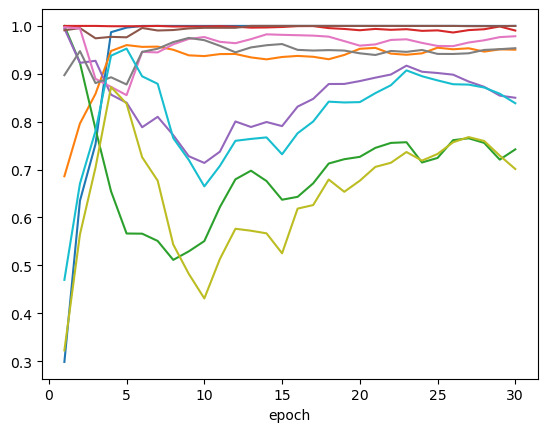

In [44]:
similarity = "cosine"
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: normalize(x, [similarity, "loss"]))
df_ratio[similarity] = (1 / df_ratio[similarity]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(lambda x: medianAbsoluteDeviation(x, similarities=[similarity]))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
# df_ratio.groupby("client_id")[similarity].plot()
df_ratio["EMA"] = df_ratio.groupby('client_id')[similarity].transform(lambda x: x.rolling(window=3, min_periods=0, center=False).mean())
df_ratio.groupby("client_id")["EMA"].plot()

In [113]:
#df_ratio.reset_index(inplace=True)
# df_ratio.loc[(df_ratio['epoch'] == 1) & (df_ratio['client_id'] == 1)] #, 'EMA'].values[0]
df_ratio.reset_index(inplace=True)
df_ratio

,epoch,client_id,label,cosine,correlation,seuclidean,loss,EMA
0,1,3,6.2,0.483103,0.286537,5.696013,0.345497,0.483103
1,1,4,6.2,1.000000,0.174443,5.871785,0.331708,1.000000
2,1,5,6.2,0.892504,0.141830,5.979137,0.322794,0.892504
3,2,3,6.2,0.745027,0.135934,5.925782,0.335486,0.614065
4,2,4,6.2,0.988861,0.123394,5.962285,0.335022,0.994430
...,...,...,...,...,...,...,...,...
85,29,4,6.2,0.988469,0.114381,6.310821,0.326896,0.969142
86,29,5,6.2,1.000000,0.114771,6.305141,0.333461,0.995715
87,30,3,6.2,0.881113,0.112108,6.269863,0.336746,0.901976
88,30,4,6.2,0.991124,0.114073,6.335701,0.326148,0.978939


In [118]:
type(df_ratio.loc[(df_ratio['epoch'] == 1) & (df_ratio['client_id'] == 3), 'EMA'].values[0] > 0)

numpy.bool_

In [15]:
def medianAbsoluteDeviation(x, similarities):
    dataset = x[similarities].values
    
    # Step 1: Calculate the median
    median = np.median(dataset)

    # Step 2: Compute the MAD
    mad = np.median(np.abs(dataset - median))

    # Step 3: Calculate the squared Mahalanobis distance for each data point
    mahalanobis_distances = ((dataset - median) / mad) ** 2

    # Step 4: Normalize the squared Mahalanobis distances
    normalized_contributions = 1 - mahalanobis_distances / np.sum(mahalanobis_distances)

    x[similarities] = normalized_contributions
    
    return x

client_id
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

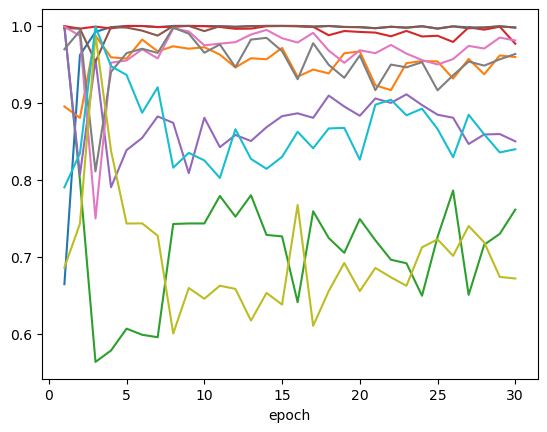

In [16]:
similarity = "cosine"
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: normalize(x, [similarity, "loss"]))
df_ratio[similarity] = (1 / df_ratio[similarity]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(lambda x: medianAbsoluteDeviation(x, similarities=[similarity]))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")[similarity].plot()

client_id
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
7    AxesSubplot(0.125,0.11;0.775x0.77)
8    AxesSubplot(0.125,0.11;0.775x0.77)
9    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

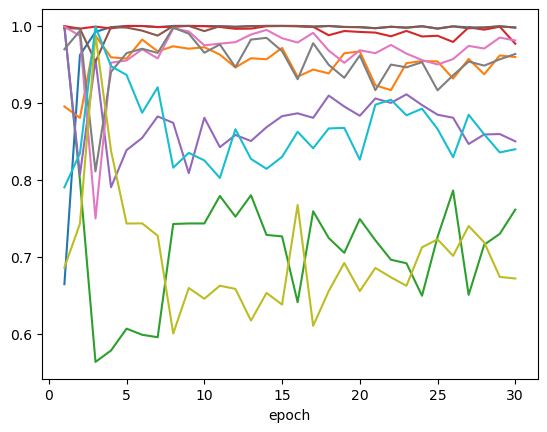

In [17]:
similarity = "cosine"
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: normalize(x, [similarity, "loss"]))
df_ratio[similarity] = (1 / df_ratio[similarity]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(lambda x: medianAbsoluteDeviation(x, similarities=[similarity]))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")[similarity].plot()

client_id
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

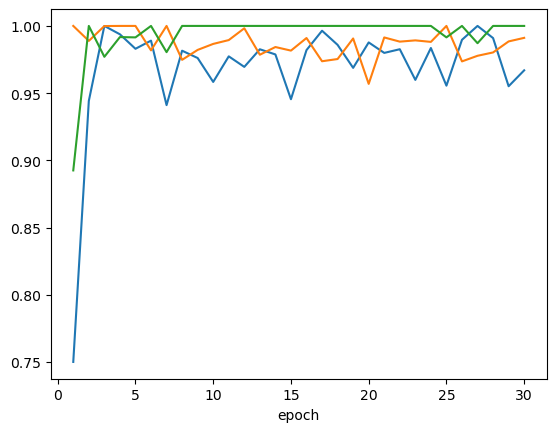

In [20]:
similarity = "cosine"
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: normalize(x, [similarity, "loss"]))
df_ratio[similarity] = (1 / df_ratio[similarity]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution_median(x, similarities=[similarity]))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")[similarity].plot()

In [597]:
cmd = ""
malicious_ids = [1, 3]
for i in range(5):
    if i > 0 :
        cmd += " & "
    cmd += "python3 client/Client.py --client_num " + str(i) + " --num_clients " + str(5)
    
    if i in malicious_ids:
        cmd += " --malicious"

In [297]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution(x, similarities=["cosine"]))
df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution(x, similarities=["loss"]))
df_ratio["cosine"] = (df_ratio["cosine"]).multiply(df_ratio["loss"], axis=0)

#df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution_mean(x))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()
#df_ratio[df_ratio.epoch == 10]

,client_id,label,cosine,correlation,seuclidean,loss
epoch,,,,,,
1,3,6.2,0.135185,0.286537,5.696013,0.550479
1,4,6.2,1.000000,0.174443,5.871785,0.528509
1,5,6.2,0.864815,0.141830,5.979137,0.514306
2,3,6.2,0.036663,0.135934,5.925782,0.498560
2,4,6.2,0.963337,0.123394,5.962285,0.497871
...,...,...,...,...,...,...
29,4,6.2,0.939996,0.114381,6.310821,0.446752
29,5,6.2,1.000000,0.114771,6.305141,0.455723
30,3,6.2,0.065805,0.112108,6.269863,0.458477


client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

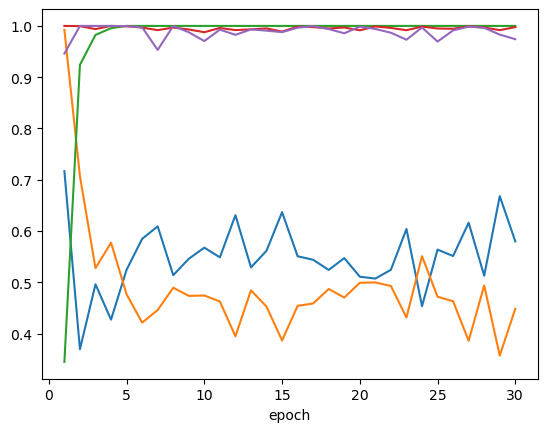

In [214]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution(x, similarities=["cosine"]))
df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution(x, similarities=["loss"]))
df_ratio["similarities"] = (df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

# df_ratio = df_ratio.groupby("epoch").apply(lambda x: point_contribution(x, similarities=["cosine"]))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

In [18]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(lambda x: medianAbsoluteDeviation(x, similarities=["cosine"], sigma=2))
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

TypeError: medianAbsoluteDeviation() got an unexpected keyword argument 'sigma'

In [19]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

TypeError: medianAbsoluteDeviation() missing 1 required positional argument: 'similarities'

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: correlation, dtype: object

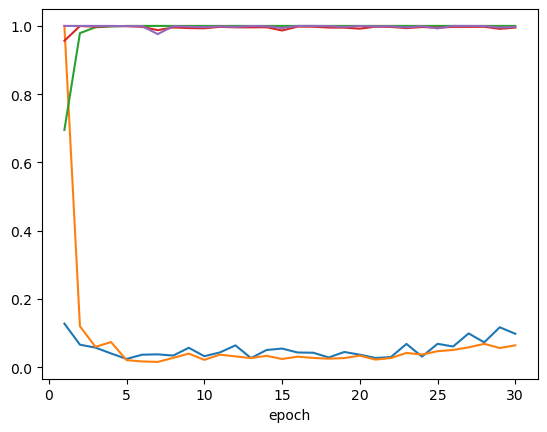

In [72]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["correlation"].plot()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: seuclidean, dtype: object

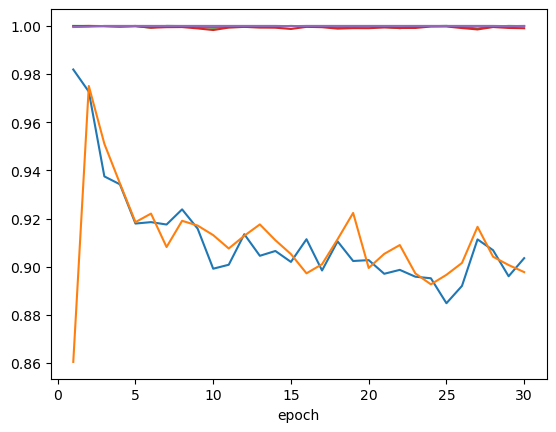

In [73]:
df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = df_ratio[similarities].multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(medianAbsoluteDeviation)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["seuclidean"].plot()

In [16]:
def softmaxScheduler(x):
    x_t = torch.from_numpy(x[similarities].to_numpy().astype(np.float32))
    x_t = torch.nn.functional.softmax(-x_t, dim=0) / (1/x_t.shape[0])
    x[similarities] = x_t.numpy()
    return x

#### Discounted Loss Contribution: 

Simple idea: The higher the loss contribution, the lower the probability that the server will perform a backpropagation step. We can use this to detect malicious clients. However, a high loss does not necessarily mean that the client is malicious. It could also be that the client has a lot of noisy data or simply that our model is still learning. 
In other word: As long as the model is learning something useful from the client, we do not want to exclude it from the training process. We measure the learning utility of a client by the mean of the per-label average cosine similarity of the latent representations of the client for each epoch:

Let 

The cosine similarity takes values between 0 and 1

To have an online detection mechanism 

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

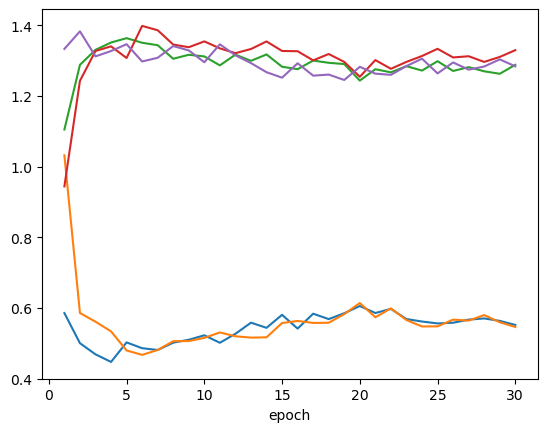

In [17]:
# df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
# df_ratio[similarities] = df_ratio[similarities].divide(df_ratio["loss"] ** 2, axis=0)

df_ratio = df_clients_global.merge(lc, on=["epoch", "client_id"])
df_ratio[similarities] = (1 / df_ratio[similarities]).multiply(df_ratio["loss"], axis=0)

df_ratio = df_ratio.groupby("epoch").apply(softmaxScheduler)
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

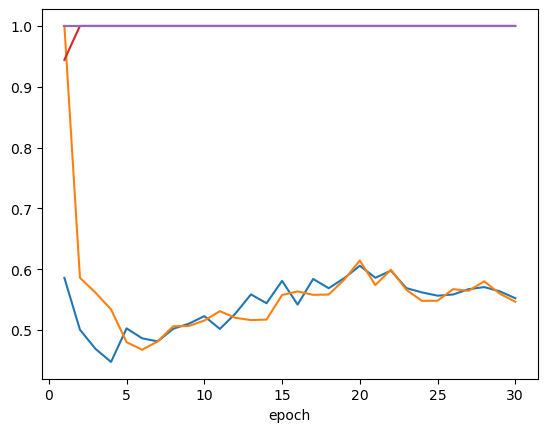

In [18]:
#clips every value in df_ratio that is greater than 1 to 1
df_ratio[similarities] = df_ratio[similarities].clip(0, 1)	
df_ratio.reset_index(inplace=True)
df_ratio.set_index("epoch", inplace=True)
df_ratio.groupby("client_id")["cosine"].plot()

## t-SNE style density estimation

In [2]:
similarities = ["cosine", "seuclidean", "euclidean"]
epochs = 30
N = 10
M = 4
p = 0.5
iid = True
base_path = f"/home/mohkoh/projects/Split_ECG_Classification/latent_space/IID={iid}_N={N}_M={M}_type=LF_p={p}"
metadata = pickle.load(open(os.path.join(base_path, "metadata.pickle"), "rb"))
df = pd.read_pickle(os.path.join(base_path, "client_1", "epoch_1.pickle"))
idxs = range(len(df))
multi_idx =  pd.MultiIndex.from_tuples(list(itertools.combinations(idxs, 2)), names=["i", "j"])

# # Generate Multi Index
# df = pd.read_pickle(os.path.join(base_path, "client_1", "epoch_1.pickle"))
# multi_idx =  pd.MultiIndex.from_tuples(list(itertools.combinations(range(len(df)), 2)), names=["i", "j"])

In [8]:
df_clients = client_scores(num_clients=5, num_workers=multiprocessing.cpu_count(), base_path=base_path, epochs=30, method="similarity", pooling="max", split="knn_10_euclidean")

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
## Per Client time for processing one epoch:

df = per_epoch_densities(client_id=1, base_path=base_path, epoch=1, similarities=["seuclidean"], sigma=1, pooling="max", split="knn_10_euclidean")

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: seuclidean, dtype: object

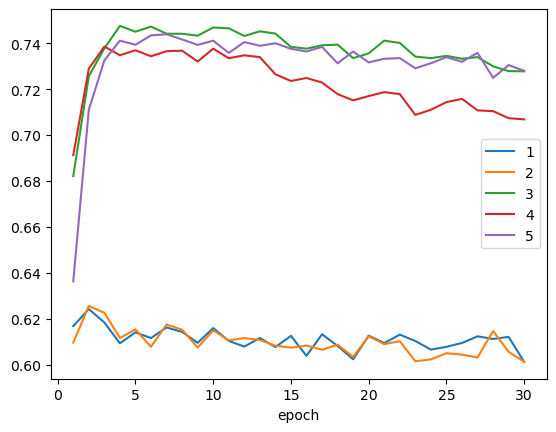

In [57]:
df_clients_global = df_clients.groupby(["client_id", "epoch"]).sum()
df_clients_global.reset_index(inplace=True)
df_clients_global.set_index("epoch", inplace=True)
df_clients_global.groupby("client_id")["seuclidean"].plot(legend=True)

In [204]:
df = pd.DataFrame()
for i in range(metadata["num_clients"]):
    df_i = pd.read_pickle(os.path.join(base_path, "client_" + str(i+1), "epoch_5.pickle"))
    df_i["client_id"] = i+1
    df = pd.concat([df, df_i], axis=0, ignore_index=True)

df = split_labels(df, split="knn_10_euclidean")  

In [214]:
X_c = df[["client_output_pooled", "label", "client_id"]]
X_c = X_c[X_c["client_id"] == 1]
X_c.reset_index(inplace=True, drop=True)
P = get_p_ij(np.array(X_c["client_output_pooled"].to_list()), sigma=1)
Y = X_c.label.unique()
sum([q_y(X_c, P, y) for y in Y])

0.6547619621426305

In [215]:
X_c = df[["client_output_pooled", "label", "client_id"]]
X_c = X_c[X_c["client_id"] == 2]
X_c.reset_index(inplace=True, drop=True)
P = get_p_ij(np.array(X_c["client_output_pooled"].to_list()), sigma=1)
Y = X_c.label.unique()
sum([q_y(X_c, P, y) for y in Y])

0.6657791045529443

In [216]:
X_c = df[["client_output_pooled", "label", "client_id"]]
X_c = X_c[X_c["client_id"] == 3]
X_c.reset_index(inplace=True, drop=True)
P = get_p_ij(np.array(X_c["client_output_pooled"].to_list()), sigma=1)
Y = X_c.label.unique()
sum([q_y(X_c, P, y) for y in Y])

0.782261764165706

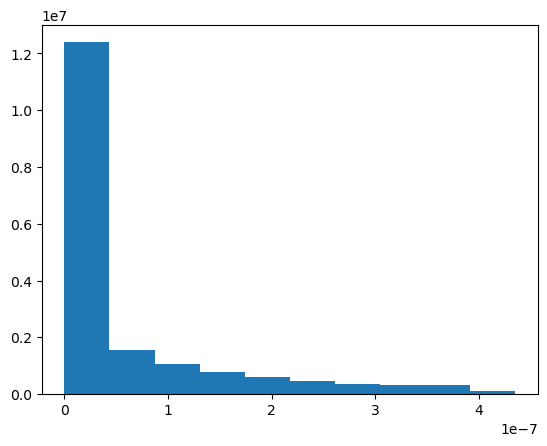

In [65]:
np.histogram(P)
plt.hist(P)
plt.show()

In [14]:
df_clients = pd.DataFrame(columns=["client_id"])
for idx in range(1, metadata["num_clients"] + 1):
    client_path = os.path.join(base_path, "client_" + str(idx))
    save_path = os.path.join(client_path, "similarities.pickle")
    df = compute_in_parallel2(client_path, epochs, similarities, sigma=2, num_workers=multiprocessing.cpu_count(), pooling=None, split="knn_10_euclidean")
    df["client_id"] = idx
    df_clients = pd.concat([df_clients, df], axis=0, ignore_index=True)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

client_id
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
Name: cosine, dtype: object

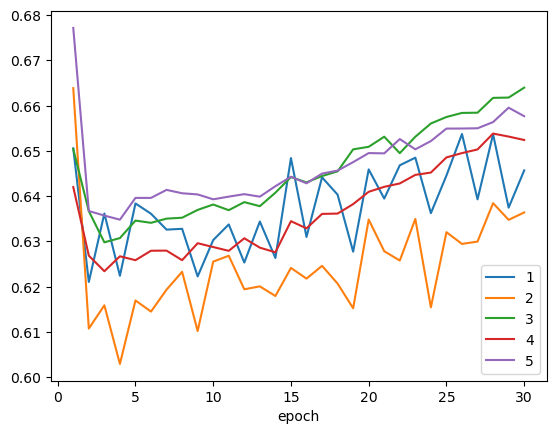

In [267]:
df_clients_global = df_clients.groupby(["client_id", "epoch"]).sum()
df_clients_global.reset_index(inplace=True)
df_clients_global.set_index("epoch", inplace=True)
df_clients_global.groupby("client_id")["cosine"].plot(legend=True)

## Testing the Detection Mechanism

In [59]:
# reads parameters from json file
import json


data = json.load(open("settings.json", "r"))
detection_params = data["detection_params"]
numclients = 5

latent_space_image = pd.DataFrame()
for i in range(1, numclients + 1):
    client_df = pd.read_pickle(os.path.join(base_path, "client_" + str(i), "epoch_10.pickle"))
    client_df["client_id"] = i
    latent_space_image = pd.concat([latent_space_image, client_df], axis=0, ignore_index=True)
    
detection_scores = pd.DataFrame()

In [60]:
def update_detection_scores(latent_space_image, detection_scores, epoch, stage="train"):
    latent_space_image = latent_space_image[latent_space_image["stage"] == stage]
    
    df_scores = pd.DataFrame()
    for client_id in tqdm(range(1, numclients + 1), desc="Client Detection Scores"):
        client_score = per_epoch_scores(epoch, client_id, df=latent_space_image, **detection_params)
        client_loss = latent_space_image[latent_space_image["client_id"] == client_id]["loss"].sum()
        client_score[detection_params["similarities"]] = (1 / client_score[detection_params["similarities"]]).multiply(client_loss, axis=0)
        df_scores = pd.concat([df_scores, client_score], ignore_index=True)
        
    df_scores = df_scores.groupby(["client_id", "epoch"]).mean().reset_index()
    df_scores = df_scores.groupby("epoch").apply(lambda x: medianAbsoluteDeviation(x, similarities=detection_params["similarities"]))
    df_scores = df_scores[["client_id", "epoch"] + detection_params["similarities"]]
    
    detection_scores = pd.concat([detection_scores, df_scores], axis=0, ignore_index=True)
        
    return detection_scores

In [61]:
detection_scores = update_detection_scores(latent_space_image, detection_scores, epoch=1, stage="val")

Client Detection Scores:   0%|          | 0/5 [00:00<?, ?it/s]

In [62]:
detection_scores

,client_id,epoch,cosine
0,1,1,0.492037
1,2,1,0.506814
2,3,1,0.000670
3,4,1,0.000000
4,5,1,0.000478


## Label Flipping Analysis

In [3]:
df = pd.read_csv('assets/label_flipping.csv')
df["AUPRC_test.max"] = df["AUPRC_test"]


In [4]:
df = pd.read_csv('assets/blending.csv')
df["AUPRC_test.max"] = df["AUPRC_test"]
df

,Name,Agent,State,Notes,User,Tags,Created,Runtime,Sweep,Average data transfer/epoch (MB):,...,F1_test.max,F1_train,F1_val,F1_val.max,FN_det.min,FP_det.min,Loss_test,Loss_val,dropout_threshold,AUPRC_test.max
0,fancy-sweep-58,plbch86t,finished,-,mohkoh,NaN,2023-06-23T06:30:00.000Z,2579,yrv3qwjh,184.53423,...,0.545651,0.485505,NaN,0.612463,NaN,NaN,0.433524,0.433524,0.009316,0.641021
1,restful-sweep-57,plbch86t,finished,-,mohkoh,NaN,2023-06-23T05:46:55.000Z,2581,yrv3qwjh,184.53423,...,0.548016,0.541245,NaN,0.591039,NaN,NaN,0.431667,0.431667,0.009316,0.645110
2,eager-sweep-56,plbch86t,finished,-,mohkoh,NaN,2023-06-23T05:03:58.000Z,2579,yrv3qwjh,184.53423,...,0.575976,0.487353,NaN,0.602024,NaN,NaN,0.415965,0.415965,0.009316,0.674395
3,solar-sweep-55,plbch86t,finished,-,mohkoh,NaN,2023-06-23T04:20:58.000Z,2579,yrv3qwjh,184.53423,...,0.542533,0.542151,NaN,0.596056,NaN,NaN,0.429677,0.429677,0.009316,0.642010
4,exalted-sweep-54,plbch86t,finished,-,mohkoh,NaN,2023-06-23T03:37:56.000Z,2581,yrv3qwjh,184.53423,...,0.561583,0.564213,NaN,0.582456,NaN,NaN,0.419518,0.419518,0.009316,0.664964
5,distinctive-sweep-53,plbch86t,finished,-,mohkoh,NaN,2023-06-23T02:54:56.000Z,2581,yrv3qwjh,184.53423,...,0.518953,0.474645,NaN,0.563309,NaN,NaN,0.438350,0.438350,0.009316,0.640848
6,glorious-sweep-52,plbch86t,finished,-,mohkoh,NaN,2023-06-23T02:11:59.000Z,2581,yrv3qwjh,184.53423,...,0.553302,0.478707,NaN,0.597786,NaN,NaN,0.423211,0.423211,0.009316,0.656366
7,stilted-sweep-51,plbch86t,finished,-,mohkoh,NaN,2023-06-23T01:28:58.000Z,2581,yrv3qwjh,184.53423,...,0.560909,0.570069,NaN,0.598379,NaN,NaN,0.426378,0.426378,0.009316,0.650182
8,lemon-sweep-50,plbch86t,finished,-,mohkoh,NaN,2023-06-23T00:46:00.000Z,2577,yrv3qwjh,184.53423,...,0.552349,0.545147,NaN,0.591121,NaN,NaN,0.426467,0.426467,0.009316,0.648165
9,sleek-sweep-49,plbch86t,finished,-,mohkoh,NaN,2023-06-23T00:02:59.000Z,2581,yrv3qwjh,184.53423,...,0.566249,0.549868,NaN,0.596434,NaN,NaN,0.424521,0.424521,0.009316,0.661057


In [61]:
# gets two plots from pandas.DataFrame.plot() and combines them into one figure
def auc_plots_attacks(dfs, bfs, title, y, label, alpha=0.1, baseline_auc=0.8292):	
    fig, ax = plt.subplots(1, len(dfs), figsize=(5*len(dfs), 5), sharey=True)
    
    for i, df in enumerate(dfs):
        df = df.copy().reset_index()
        df["AUC_test.max"] = df["AUC_test.max"].ewm(alpha=alpha).mean().clip(0, baseline_auc)
                
        for p in df[y].unique():
            baseline = {
                "AUPRC_test.max": 0.6503,
                "AUC_test.max": 0.8292,
                y: p,
                "num_malicious": 0,
            }
            df.loc[len(df)] = baseline
            

        df[y] = df[y].apply(lambda x: f"${label}={x}$")
        df = df.sort_values(by="num_malicious")

        
        df = df.reset_index().set_index("num_malicious").groupby(y)
        df["AUC_test.max"].plot(x=[0, 2, 4, 6, 8, 10], ax=ax[i], legend=False, linewidth=2.5)	
        ax[i].set_xlabel("$M$")	
        ax[i].axhline(y=baseline_auc, c='black', linestyle='dashed', label="baseline", linewidth=2.5)
        
        if bfs[i] > 0:
            ax[i].set_title(f"Data Perturbation Attack $(\\alpha={bfs[i]})$", fontsize=14)
        else:
            ax[i].set_title(f"Label Flipping Attack $(\\alpha={bfs[i]})$", fontsize=14)

        if i == 0:
            ax[i].legend()
            ax[i].set_ylabel("AUROC")	
            
    
    #fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_2732024/387913100.py:16: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[len(df)] = baseline
/tmp/ipykernel_2732024/387913100.py:16: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[len(df)] = baseline
/tmp/ipykernel_2732024/387913100.py:16: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  d

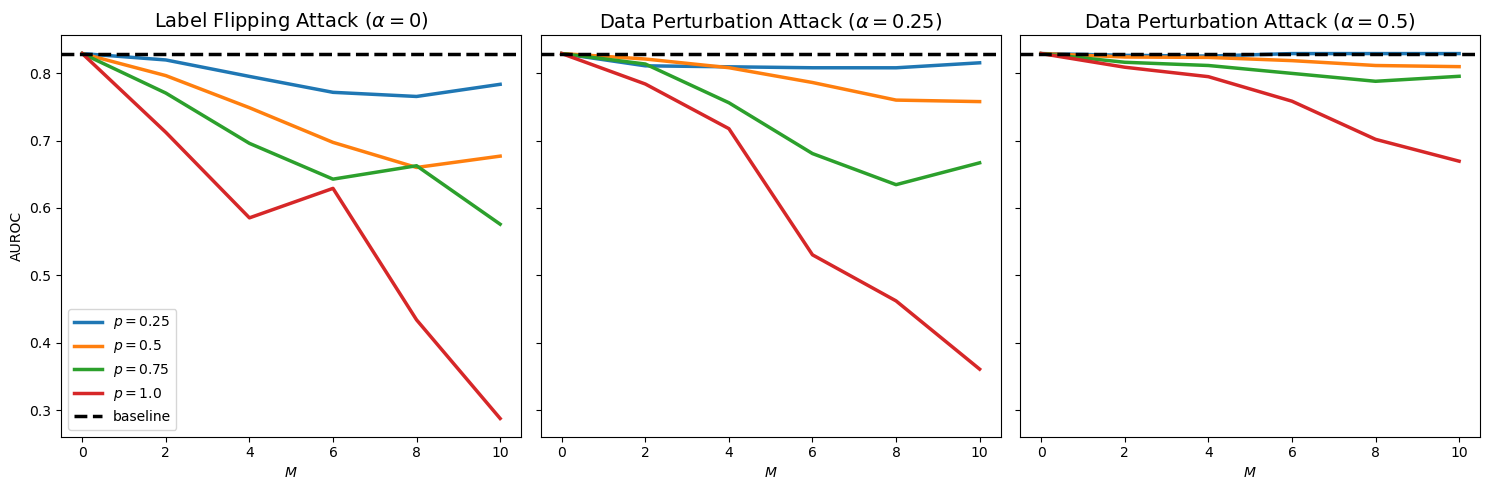

In [62]:
t0 = 0
dt = 5
theta = 3
dfs = []
bfs = [0, 0.25, 0.5]

for bf in bfs:
    attack = "blending" if bf > 0 else "label_flipping"
    df = pd.read_csv(f"/home/mohkoh/projects/Split_ECG_Classification/assets/{attack}.csv")
    if bf > 0:
        df = df[df["blending_factor"] == bf]
    else:
        df["data_poisoning_prob"] = df["label_flipping_prob"]

    dfs.append(df)
    
auc_plots_attacks(dfs, bfs, y="data_poisoning_prob", alpha=.7, title=f"Data Poisoning Attacks without Detection Mechanism", label="p")

## Detection in Training Analysis

In [57]:
# gets two plots from pandas.DataFrame.plot() and combines them into one figure
def auc_plots(dfs, ps, title, y, label, alpha=0.1, baseline_auc=0.838):	
    fig, ax = plt.subplots(1, len(dfs), figsize=(5*len(dfs), 5), sharey=True)
    
    for i, df in enumerate(dfs):
        df = df.copy().reset_index()
        df["AUC_test.max"] = df["AUC_test.max"].ewm(alpha=alpha, adjust=True).mean().clip(0, baseline_auc)
        
        for p in df[y].unique():
            baseline = {
                "AUC_test.max": baseline_auc,
                y: p,
                "num_malicious": 0,
            }
            df.loc[len(df)] = baseline
            

        df[y] = df[y].apply(lambda x: f"${label}={x}$" if x < 1.0 else "no detection")
        df_ref = df[df[y] == "no detection"].reset_index().set_index("num_malicious").groupby(y)
        df = df[df[y] != "no detection"].reset_index().set_index("num_malicious").groupby(y)
        
        df["AUC_test.max"].plot(x=[0, 2, 4, 6, 8, 10], ax=ax[i], legend=False,  linewidth=2.5)	
        df_ref["AUC_test.max"].plot(x=[0, 2, 4, 6, 8, 10], ax=ax[i], legend=False, style='--', linewidth=2.5)	
        ax[i].set_xlabel("$M$")	
        ax[i].axhline(y=baseline_auc, c='black', linestyle='dashed', label="baseline")
        ax[i].set_title(f"$p={ps[i]}$", fontsize=14)
        
        if i == 0:
            ax[i].legend()
            ax[i].set_ylabel("AUROC")	
    
    #fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_2732024/3220429847.py:15: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[len(df)] = baseline
/tmp/ipykernel_2732024/3220429847.py:15: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[len(df)] = baseline
/tmp/ipykernel_2732024/3220429847.py:15: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.


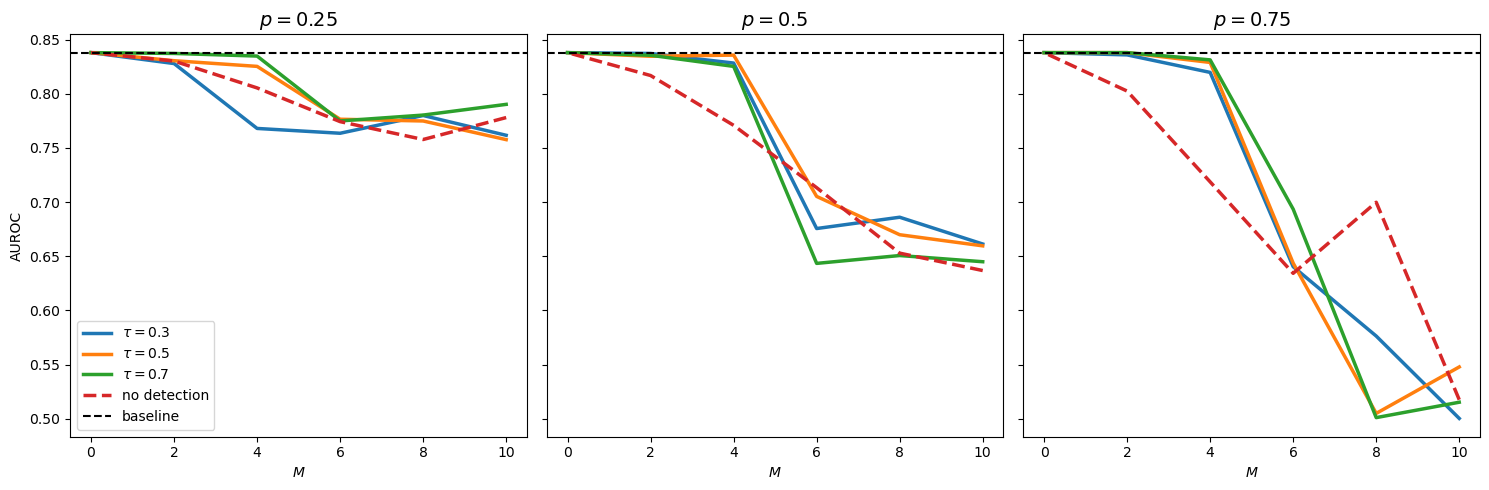

In [58]:
t0 = 0
dt = 5
theta = 3
dfs = []
ps = [0.25, 0.5, 0.75]

for p in ps:
    df = pd.read_csv(f"/home/mohkoh/projects/Split_ECG_Classification/assets/detection_lf_{p}.csv")

    df_ref = pd.read_csv('assets/label_flipping.csv')
    df_ref = df_ref[df_ref['label_flipping_prob'] == p]
    df_ref.detection_tau = 1.0
    df_ref["AUPRC_test.max"] = df_ref["AUPRC_test"]
    df_exp = df[(df["detection_tau"] < 0.9) &(df["detection_start"] == t0) & (df["detection_window"] == dt) & (df["detection_tolerance"] == theta)].copy()
    df_exp = pd.concat([df_exp, df_ref], axis=0, ignore_index=True)
    dfs.append(df_exp)
    
auc_plots(dfs, ps, y="detection_tau", alpha=1, title=f"Label Flipping Attack with Detection Mechanism \n ($t_0={t0}$, $\Delta t={dt}$, $\\theta={theta}$)", label="\\tau")

In [80]:
df = pd.read_csv("/home/mohkoh/projects/Split_ECG_Classification/assets/detection_lf_0.75.csv")
tmp = pd.read_csv("/home/mohkoh/projects/Split_ECG_Classification/assets/tmp_2.csv")

row = df[(df["detection_tau"] == 0.5) & (df["num_malicious"] == 4)].copy()
tmp[(tmp["detection_tau"] == 0.5) & (tmp["num_malicious"] == 4)]["AUC_test.max"]
row["AUC_test.max"] = tmp[(tmp["detection_tau"] == 0.5) & (tmp["num_malicious"] == 4)]["AUC_test.max"].values[0]
df[(df["detection_tau"] == 0.5) & (df["num_malicious"] == 4)] = row 

df.to_csv("/home/mohkoh/projects/Split_ECG_Classification/assets/detection_lf_0.75.csv", index=False)

In [34]:
df = pd.read_csv("/home/mohkoh/projects/Split_ECG_Classification/assets/detection_lf_0.75.csv")
df_tmp = pd.read_csv("/home/mohkoh/projects/Split_ECG_Classification/assets/tmp.csv")
df = df.append(df_tmp, ignore_index=True)
df.to_csv("/home/mohkoh/projects/Split_ECG_Classification/assets/detection_lf_0.75.csv", index=False)

/tmp/ipykernel_3682689/4271715418.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_tmp, ignore_index=True)


/tmp/ipykernel_3678788/2437221238.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df.loc[len(df)] = baseline


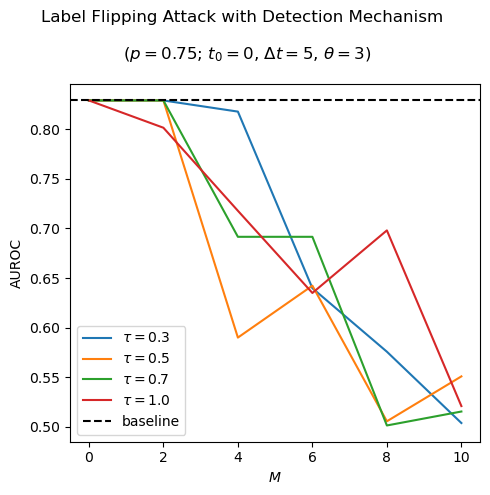

In [36]:
for t0 in [0]:
    for dt in [5]:
        for theta in [3]:
            df_exp = df[(df["detection_tau"] < 0.9) &(df["detection_start"] == t0) & (df["detection_window"] == dt) & (df["detection_tolerance"] == theta)].copy()
            df_exp = pd.concat([df_exp, df_ref], axis=0, ignore_index=True)
            auc_plot(df_exp, alpha=0.99, y="detection_tau", label="\\tau", title=f"Label Flipping Attack with Detection Mechanism \n\n ($p=0.75$; $t_0={t0}$, $\Delta t={dt}$, $\\theta={theta}$)")

## Detections Scores and States

In [51]:

def plot_scores_states(num_malicious, p, client_ids, malicious_ids, tau):
    df_scores = pd.read_csv(f"/home/mohkoh/projects/Split_ECG_Classification/assets/detection_scores_table_M={num_malicious}_p={p}.csv")
    df_states = pd.read_csv(f"/home/mohkoh/projects/Split_ECG_Classification/assets/detection_states_table_M={num_malicious}_p={p}.csv")
    
    client_ids_str = [f"client_{i}" for i in client_ids]
        
    fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True, squeeze=True, gridspec_kw = {'height_ratios':[2, 1]})

    for i, client_id in enumerate(client_ids_str):
        df = df_scores[df_scores["lineKey"] == client_id]
        df.set_index("step").groupby("lineKey")["lineVal"].plot(legend=False, style="-" if client_ids[i] not in malicious_ids else "--", ax=ax[0], linewidth=2)
    ax[0].axhline(y=tau, c='black', linestyle='dotted', label="$\\tau$")
    handles, labels = ax[0].get_legend_handles_labels()

    labels = [f"$c_{i}$" for i in client_ids] + ["$\\tau$"]
    ax[0].legend(handles=handles, labels=labels)
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("$\widehat{DL}_i$")
    ax[0].set_title(f"($M={num_malicious}$, $p={p}$, $\\tau={tau}$)", fontsize=14)
    
    # Sets the margin between the two plots to 0
    plt.subplots_adjust(hspace=0.05)	

    ax[1].set_ylim([-1.5, 1.5])
    ax[1].set_yticks([-1, 0, 1])
    for i, client_id in enumerate(client_ids_str):
        df = df_states[df_states["lineKey"] == client_id]
        df.set_index("step").groupby("lineKey")["lineVal"].plot(legend=False, style="-" if client_ids[i] not in malicious_ids else "--", ax=ax[1], linewidth=2)
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("State")
    #fig.suptitle(f"Detection Scores and States", fontsize=14)
    fig.show()

    return fig, ax

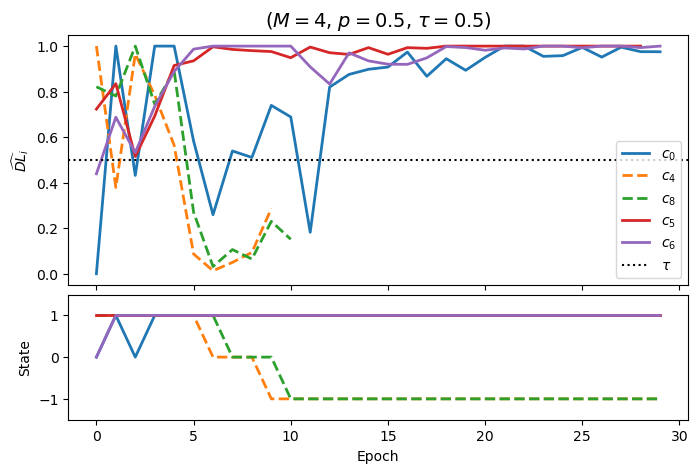

In [52]:
num_malicious = 4
p = 0.5
client_ids = [0, 4, 8, 5, 6]
malicious_ids = [4, 8]

ax_4 = plot_scores_states(num_malicious, p, client_ids, malicious_ids, tau=0.5)

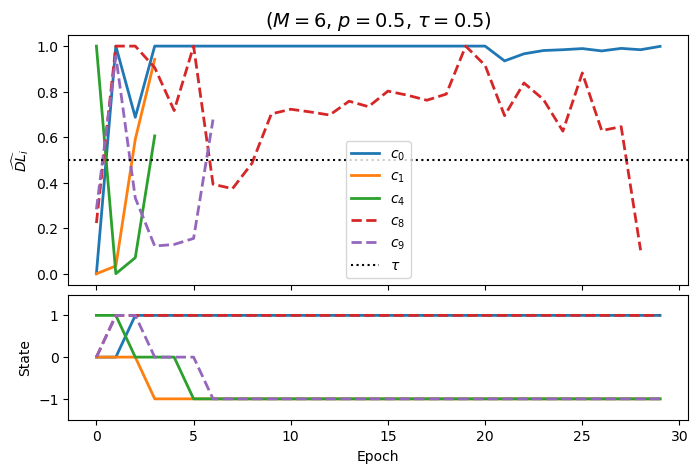

In [53]:
num_malicious = 6
p = 0.5
client_ids = [0, 1, 4, 8, 9]
malicious_ids = [8, 9]

ax_6 = plot_scores_states(num_malicious, p, client_ids, malicious_ids, tau=0.5)

(<Figure size 800x500 with 2 Axes>,
 array([<AxesSubplot:title={'center':'($M=4$, $p=0.25$, $\\tau=0.3$)'}, xlabel='Epoch', ylabel='$\\widehat{DL}_i$'>,
        <AxesSubplot:xlabel='Epoch', ylabel='State'>], dtype=object))

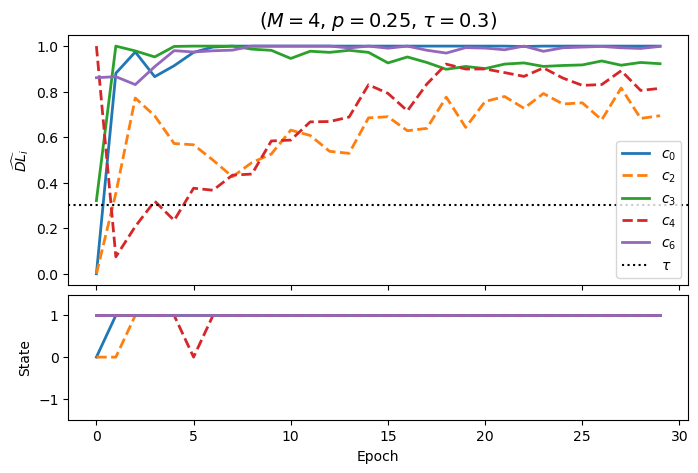

In [54]:
num_malicious = 4
p = 0.25
client_ids = [0, 2, 3, 4, 6]
malicious_ids = [2, 4]

plot_scores_states(num_malicious, p, client_ids, malicious_ids, tau=0.3)